# Q.1 How are guests experiencing their stay in Airbnb in Florence?

## Table of Contents:


* [Sentiment Analysis](#chapter3)
    * [Polarity Estimation](#chapter3.1)
    * [Ratings vs Polarity](#chapter3.2)
    * [Word Cloud Visualization](#chapter3.3)
        * [Data pre-processing: bigrams and trigrams](#chapter3.3.1)
        * [Word Cloud Plots](#chapter3.3.2)

### Import Libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(style="whitegrid")


import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en.examples import sentences

import pickle 

from nltk.tokenize import word_tokenize

import nltk
#nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')
#nltk.download('averaged_perceptron_tagger')

from PIL import Image

from wordcloud import WordCloud, STOPWORDS


[Back to TOC](#Table-of-Contents:)

<a class="anchor" id='chapter3'></a>

# Sentiment Analysis


<a class="anchor" id='chapter3.1'></a>
## Polarity Estimation

**VADER** (Valence Aware Dictionary and sEntiment Reasoner) is a **lexicon and rule-based sentiment analysis tool** that is specifically attuned to sentiments expressed in social media.<br> 
VADER uses a combination of sentiment lexicon from a list of lexical features (e.g., words) which are generally labelled according to their semantic orientation as either positive or negative.<br>
VADER has been found to be quite successful when dealing with social media texts, NY Times editorials, movie reviews, and product reviews. This is because VADER not only tells about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is.<br>

In the following analysis, we use the **compound score**. <br>
The compound is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. 

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values are:<br>

* **positive sentiment:** compound score >= 0.5 <br>
* **neutral sentiment:** (compound score > -0.5) and (compound score < 0.5) <br>
* **negative sentiment:** compound score <= -0.5 <br>

**Reference:**<br>
*"Hutto, C., & Gilbert, E. (2014, May). Vader: A parsimonious rule-based model for sentiment analysis of social media text. In Proceedings of the International AAAI Conference on Web and Social Media (Vol. 8, No. 1).* http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf <br>
Fully open-sourced under the MIT License. https://github.com/cjhutto/vaderSentiment 



In [15]:
# Upload data

df_reviews_sample = pd.read_pickle('./data/df_reviews_sample.pkl')

In [16]:
df_reviews_sample.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,length_comments,language,en_translation
39978,735370,151499476,2017-05-13,107924476,Jutta,eine schön gelegene wohnung in der etage die w...,59,de,a beautifully located apartment on the same fl...
196555,5909451,142261214,2017-04-07,118986470,Michael,alles bestens sehr gute lage nahe der piazza d...,25,de,"everything was very good, very good location n..."
340512,14976201,437134397,2019-04-14,129853528,Kristine,das airbnb hat uns sehr gut gefallen wir haben...,120,de,"We liked the airbnb very much, although we onl..."
189256,5745043,658966293,2020-08-31,160489786,Mark,perfekt für einen urlaub in florenz und der an...,15,de,perfect for a vacation in florence and traveli...
149460,4143454,179633637,2017-08-08,97926976,Uwe,wir hatten als familie pesonen eine sehr schö...,96,de,we had a very nice time as a family pesonen in...


In [17]:
df_reviews_sample.shape

(51047, 9)

In [18]:
# Create a unique column with all comments in English

df_reviews_sample['en_translation'].fillna(df_reviews_sample['comments'], inplace=True)
df_reviews_sample = df_reviews_sample.rename(columns={'en_translation': 'comments_english'})

In [19]:
# Create a SentimentIntensityAnalyzer object

analyzer = SentimentIntensityAnalyzer()

In [20]:
# polarity_scores method of SentimentIntensityAnalyzer object gives a sentiment dictionary
# which contains pos, neg, neu, and compound scores.
# We will keep the compound score.

polarity_compound = lambda s: (analyzer.polarity_scores(s))['compound']

In [21]:
# Add a new column with the polarity_compound score to the dataframe

df_reviews_sample['polarity_compound'] = df_reviews_sample['comments_english'].map(polarity_compound)

In [22]:
# Check some random reviews with negative, neutral and positive polarity_compound
# negative

neg_score = df_reviews_sample['polarity_compound'].loc[334506]
print(f'polarity: {neg_score}')
neg_comment = df_reviews_sample['comments_english'].loc[334506]
print(f'comment: {neg_comment}')
print('')

# neutral
neu_score = df_reviews_sample['polarity_compound'].loc[480491]
print(f'polarity: {neu_score}')
neu_comment = df_reviews_sample['comments_english'].loc[480491]
print(f'comment: {neu_comment}')
print('')

# positive
pos_score = df_reviews_sample['polarity_compound'].loc[3766]
print(f'polarity: {pos_score}')
pos_score = df_reviews_sample['comments_english'].loc[3766]
print(f'comment: {pos_score}')
print('')

polarity: -0.5423
comment: bad instructions parking unreasonable

polarity: 0.0
comment: corresponded to the expectations parking in the immediate vicinity even for buses

polarity: 0.9
comment: i highly recommend this place  original art on the walls charming interior books in the dining room  carla greeted me with a big smile  this is not the place for those who are demanding but for those who can see beauty in the way ordinary people live



In [23]:
# define a function that classifies polarity score as positive, neutral and negative

def sentiment(x):
    ''' Function that given a Polarity Score
    classifies it as positive, neutral and negative
    '''
    if x >= 0.5:
        return 'pos'
    if x < 0.5 and x > -0.5:
        return 'neu'
    if x < -0.5:
        return 'neg'
    return ''

In [24]:
# Add a new column with sentiment

df_reviews_sample['sentiment'] = df_reviews_sample['polarity_compound'].apply(sentiment)

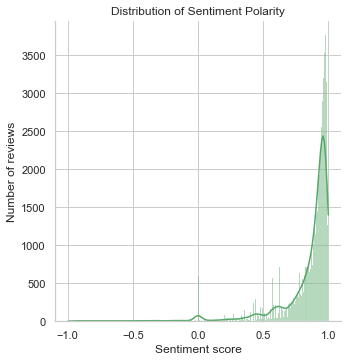

In [25]:
# Let's explore the distribution of reviews' sentiment score

ax = sns.displot(df_reviews_sample['polarity_compound'], kde=True, color='g')
ax.set(xlabel='Sentiment score', ylabel='Number of reviews', title = 'Distribution of Sentiment Polarity' )
plt.show()

In [27]:
ax.savefig('distrubtion_sentiment_polarity.png',dpi=600)

In [18]:
df_reviews_sample['sentiment'].value_counts(normalize=True)*100

pos    92.444218
neu     6.862303
neg     0.693479
Name: sentiment, dtype: float64

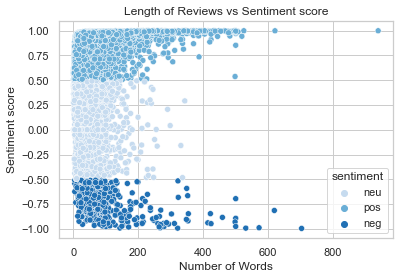

In [29]:
ax = sns.scatterplot(data=df_reviews_sample, 
                     y='polarity_compound', 
                     x='length_comments', 
                     hue='sentiment', 
                     palette = 'Blues')

ax.set(xlabel='Number of Words', ylabel='Sentiment score', title = 'Length of Reviews vs Sentiment score' )

plt.show()

In [31]:
ax.figure.savefig('length_reviews_polarity.png',dpi=600)

In [20]:
# Explore more details about the length of reviews by sentiment

df_reviews_sample.groupby(df_reviews_sample['sentiment']).length_comments.agg(['mean','median','min','max','count']).round(2)

,mean,median,min,max,count
sentiment,,,,,
neg,108.55,75.5,4,703,354
neu,29.98,19.0,1,343,3503
pos,54.78,43.0,1,939,47190


Some **insights**:
1. Most Airbnb comments in our sample are **positive (92.4%)**, as we can see from the very right-skewed distribution. Only about **0.7%** of the analyzed reviews are **negative** and **6.9%** are **neutral**. <br>
2. There are two small picks in the sentiment distribution: one is around zero, reflecting the neutral sentiment, and the second when the score is positive but low. Relating the sentiment score to the length of reviews, we see that **shorter reviews tend to have lower or neutral sentiment scores**.<br>
3. On average, **negative reviews are longer** also considering the presence of some outliers.<br>
4. The **most common type of review** (the largest pick in sentiment distribution) is **overall very positive**.



In [ ]:
#df_reviews_sample.to_pickle('./data/df_reviews_sample_sentiment.pkl')

In [3]:
df_reviews_sample_sentiment = pd.read_pickle('./data/df_reviews_sample_sentiment.pkl')

[Back to TOC](#Table-of-Contents:)
<a class="anchor" id='chapter3.2'></a>
## Ratings vs Polarity

In [34]:
# Upload Listings data cleaned

df_clean_listings = pd.read_pickle('./data/df_clean_listings.pkl')

In [37]:
df_clean_listings.head()

,id,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,...,host_identity_verified_t,neighbourhood_cleansed_Campo di Marte,neighbourhood_cleansed_Centro Storico,neighbourhood_cleansed_Gavinana Galluzzo,neighbourhood_cleansed_Isolotto Legnaia,neighbourhood_cleansed_Rifredi,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,24469,100.0,100.0,5.0,5.0,43.78210,11.24392,4,1.0,1.0,...,1,0,1,0,0,0,1,0,0,0
1,24470,100.0,100.0,5.0,5.0,43.78202,11.24399,3,1.0,1.0,...,1,0,1,0,0,0,1,0,0,0
2,24471,100.0,100.0,5.0,5.0,43.78202,11.24399,6,2.0,2.0,...,1,0,1,0,0,0,1,0,0,0
3,24472,100.0,100.0,5.0,5.0,43.78202,11.24399,6,2.0,2.0,...,1,0,1,0,0,0,1,0,0,0
4,31840,100.0,100.0,32.0,32.0,43.77709,11.25216,2,1.0,1.0,...,1,0,1,0,0,0,0,0,1,0


In [38]:
# Select useful columns for the analysis 

selection_listings = df_clean_listings[['id', 
                                        'number_of_reviews', 
                                        'review_scores_rating', 
                                        'review_scores_accuracy', 
                                        'review_scores_cleanliness', 
                                        'review_scores_checkin', 
                                        'review_scores_communication', 
                                        'review_scores_location', 
                                        'review_scores_value',
                                        'neighbourhood_cleansed_Campo di Marte',
                                        'neighbourhood_cleansed_Centro Storico',
                                        'neighbourhood_cleansed_Gavinana Galluzzo',
                                        'neighbourhood_cleansed_Isolotto Legnaia',
                                        'neighbourhood_cleansed_Rifredi',
                                        'price_per_person',
                                        'price',
                                        'number_of_reviews_ltm',
                                        'number_of_reviews_l30d'
                                        ]]

In [39]:
# Compute the average polarity per listing

listing_polarity = pd.DataFrame(df_reviews_sample_sentiment.groupby(['listing_id']).mean()['polarity_compound'])

In [40]:
# Merge average polarity with listing ratings

df_ratings_polarity = pd.merge(selection_listings, listing_polarity, left_on='id', right_on='listing_id', how='left')

In [41]:
print(f'Missing polarity score for {df_ratings_polarity.polarity_compound.isnull().sum()} listings')

Missing polarity score for 5004 listings


In [42]:
review_scores_price = ['review_scores_rating', 
                'review_scores_accuracy', 
                'review_scores_cleanliness', 
                'review_scores_checkin', 
                'review_scores_communication', 
                'review_scores_location', 
                'review_scores_value',
                'polarity_compound',
                'price_per_person',
                'price',
                'number_of_reviews',
                'number_of_reviews_ltm',
                'number_of_reviews_l30d'
                ]


- **review_scores_rating** indicates the overall experience. "How was it?"
- **review_scores_cleanliness** refers to cleanliness. "Did the place meet our standards?"
- **review_scores_accuracy** refers to Accuracy. "Was it accurately represented with up-to-date photos and info?"
- **review_scores_checkin** refers to Check-in. "Should be easy."
- **review_scores_communication** refers to Communication. "Did the Host respond to messages promptly?"
- **review_scores_location** refers to Location. "Was the guest made aware of safety, transportation, points of interest and special considerations like noise or other situations that might affect their stay?"
- **review_scores_value** refers to  Value. "Was it worth the price?"

Source: https://www.airbnb.com/help/article/1257/star-ratings


In [43]:
df_ratings_polarity[review_scores_price].describe()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,polarity_compound,price_per_person,price,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d
count,10993.000000,10993.000000,10993.000000,10993.000000,10993.000000,10993.000000,10993.000000,5989.000000,10993.000000,10993.000000,10993.000000,10993.000000,10993.000000
mean,4.664704,4.792912,4.763145,4.843109,4.837387,4.809160,4.698604,0.825502,36.619745,124.807605,47.699263,2.452834,0.393250
std,0.508678,0.308080,0.326024,0.263205,0.280001,0.260064,0.318915,0.162189,84.826603,299.007797,80.917336,7.103005,1.224484
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.977800,1.125000,9.000000,0.000000,0.000000,0.000000
25%,4.649389,4.780000,4.750000,4.833370,4.830277,4.778784,4.670000,0.784100,16.666667,55.000000,1.000000,0.000000,0.000000
50%,4.700000,4.820000,4.790000,4.870000,4.875000,4.845787,4.712798,0.866571,23.400000,78.000000,10.000000,0.000000,0.000000
75%,4.900000,4.950000,4.950000,4.990000,4.990000,4.980000,4.860000,0.923000,35.000000,119.000000,59.000000,1.000000,0.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.999300,3499.500000,13396.000000,812.000000,111.000000,14.000000


**On average the rating scores and the polarity score are pretty high.**

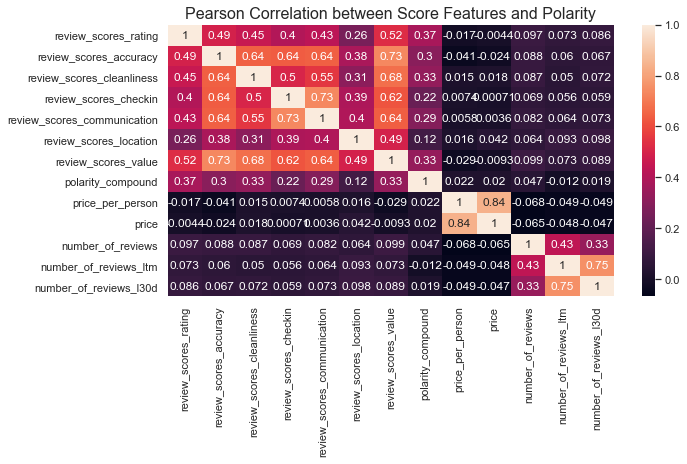

In [50]:
# Exploring correlations

corr = df_ratings_polarity[review_scores_price].corr()

plt.figure(figsize=(10,5))
ax = sns.heatmap(corr, annot=True)
plt.title('Pearson Correlation between Score Features and Polarity', fontsize=16);
plt.show()

In [51]:
ax.figure.savefig('corr_rating_polarity.png', dpi=600, bbox_inches = "tight")

Looking at correlations:
- There is a **strong correlation** (0.73) between **review_score_communication** and **review_score_checkin**
- There is a **strong correlation** (0.73) between **review_score_value** and **review_score_accuracy**, and also **review_score_cleaninless**
- There is a **moderate positive association** between the **polarity score** and the **review_score_rating**
- There is a **strong correlation** between the **number of reviews in the last 12 months** and the **number of monthly reviews**

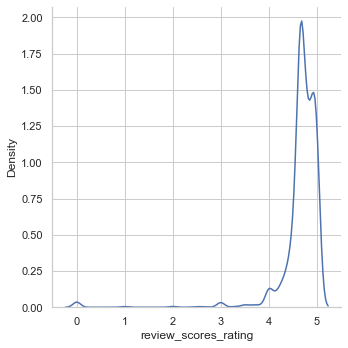

In [218]:
# Compare the review_score_rating distribution with the polarity score distribution

sns.displot(df_ratings_polarity, x="review_scores_rating", kind='kde')

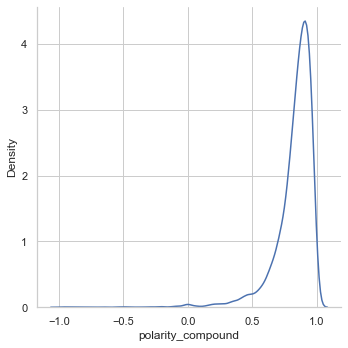

In [219]:
sns.displot(df_ratings_polarity, x="polarity_compound", kind='kde')

### Explore ratings, polarity, prices, number of review by neighborhoods

In [205]:
# The city of Florence has 5 neighborhoods.

# Centro Storico
df_centro = pd.DataFrame(df_ratings_polarity[review_scores_price][df_ratings_polarity['neighbourhood_cleansed_Centro Storico'] == 1].mean())                         

# Campo di Marte
df_campo_marte = pd.DataFrame(df_ratings_polarity[review_scores_price][df_ratings_polarity['neighbourhood_cleansed_Campo di Marte'] == 1].mean())                         

# Gavinana-Galluzzo
df_Gavinana = pd.DataFrame(df_ratings_polarity[review_scores_price][df_ratings_polarity['neighbourhood_cleansed_Gavinana Galluzzo'] == 1].mean())

#Isolotto-Legnaia
df_isolotto = pd.DataFrame(df_ratings_polarity[review_scores_price][df_ratings_polarity['neighbourhood_cleansed_Isolotto Legnaia'] == 1].mean())

# Rifredi
df_rifredi = pd.DataFrame(df_ratings_polarity[review_scores_price][df_ratings_polarity['neighbourhood_cleansed_Rifredi'] == 1].mean())

In [226]:
neighborhoods = ['Centro Storico', 'Campo di Marte', 'Gavinana Galluzzo', 'Isolotto Legnaia', 'Rifredi']
df_neighborhoods_sum = pd.concat([df_centro, df_campo_marte, df_Gavinana, df_isolotto, df_rifredi], axis=1)
df_neighborhoods_sum.columns = neighborhoods
df_neighborhoods_sum

,Centro Storico,Campo di Marte,Gavinana Galluzzo,Isolotto Legnaia,Rifredi
review_scores_rating,4.664704,4.693982,4.680382,4.714825,4.620606
review_scores_accuracy,4.792912,4.814569,4.795904,4.838867,4.789902
review_scores_cleanliness,4.763145,4.787710,4.775991,4.814322,4.755561
review_scores_checkin,4.843109,4.863915,4.859863,4.893576,4.845525
review_scores_communication,4.837387,4.850887,4.833802,4.882714,4.829570
review_scores_location,4.809160,4.691036,4.669412,4.692985,4.618097
review_scores_value,4.698604,4.715521,4.680150,4.735108,4.677777
polarity_compound,0.825502,0.829049,0.855595,0.835597,0.806763
price_per_person,36.619745,35.464383,46.015104,23.592547,23.668729
price,124.807605,110.747253,183.272926,72.349680,82.509605


[Back to TOC](#Table-of-Contents:)
<a class="anchor" id='chapter3.3'></a>

## Word Cloud Visualization

We use **word cloud visual representation** to have an idea of **keywords** that appear more frequently in **positive** and **negative reviews**.<br>
The most frequent words are represented with bigger and bold letters. The smaller the size of the words the lesser it's important. <br> 


**Reference:** <br> 
Fully open-sourced under the MIT License. https://github.com/amueller/word_cloud<br> 


<a class="anchor" id='chapter3.3.1'></a>
### Data pre-processing: bigrams and trigrams

In [25]:
# Identify bigrams: bigrams are phrases containing 2 words that commonly co-occur. For example, 'ice cream','ice', 'cream'.

def find_bigram(x,n):
    
    ''' Function that identifies bigrams in a corpus
        inputs:
        x - corpus
        n - minimum number of times bigrams occur in the corpus 
        output:
        Pointwise Mutual Information score '''
    
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in x])

    finder.apply_freq_filter(n)
    bigram_scores = finder.score_ngrams(bigram_measures.pmi)
    return bigram_scores

In [26]:
# Identify bigrams in our reviews

bigram_pmi = pd.DataFrame(find_bigram(df_reviews_sample_sentiment['comments_english'],200))
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [27]:
# Identify trigrams
def find_trigram(x,n):
    
    ''' Function that identifies trigrams in a corpus
        inputs:
        x - corpus
        n - minimum number of times trigrams occur in the corpus 
        output:
        Pointwise Mutual Information score '''
    
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in x])

    finder.apply_freq_filter(n)
    trigram_scores = finder.score_ngrams(trigram_measures.pmi)
    return trigram_scores

In [28]:
# Identify trigrams in our reviews

trigram_pmi = pd.DataFrame(find_trigram(df_reviews_sample_sentiment['comments_english'],200))
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [29]:
# Include bigrams with only noun-type structures 

def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in STOP_WORDS or bigram[1] in STOP_WORDS:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

In [30]:
# Include trigrams with only noun-type structures 

def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in STOP_WORDS or trigram[-1] in STOP_WORDS or trigram[1] in STOP_WORDS:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True 

In [31]:
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:
                                              bigram_filter(bigram['bigram'])
                                              and bigram.pmi > 5, axis = 1)][:500]
bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]

In [32]:
filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram:
                                                 trigram_filter(trigram['trigram'])
                                                 and trigram.pmi > 5, axis = 1)][:500]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [33]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '-'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '-'.join(gram.split()))
    return x

In [34]:
# Replace ngrams in the comments_english column

df_reviews_sample_sentiment.comments_english = df_reviews_sample_sentiment.comments_english.map(lambda x: replace_ngram(x))

<a class="anchor" id='chapter3.3.2'></a>
### Word Cloud Plots

In [44]:
# Define a function to plot word cloud

def plot_cloud(x):
    plt.figure(figsize=(40,30)) # set figure size
    plt.imshow(x) # display data as image
    plt.axis('off') # do not display axis details

In [45]:
# Generate Word Cloud for positive and negative sentiments

def gen_word_cloud(text,image):
    mask = np.array(Image.open(image))
    wordcloud = WordCloud(width = 1000, 
                          height = 500, 
                          random_state = 42, 
                          background_color = 'white', 
                          colormap ='Set2', 
                          collocations = False, 
                          stopwords = STOP_WORDS,
                          max_words = 200,
                          mask = mask).generate(str(text))
    plot_cloud(wordcloud)
    
    wordcloud.to_file(f"wordcloud_{image}") # Save image

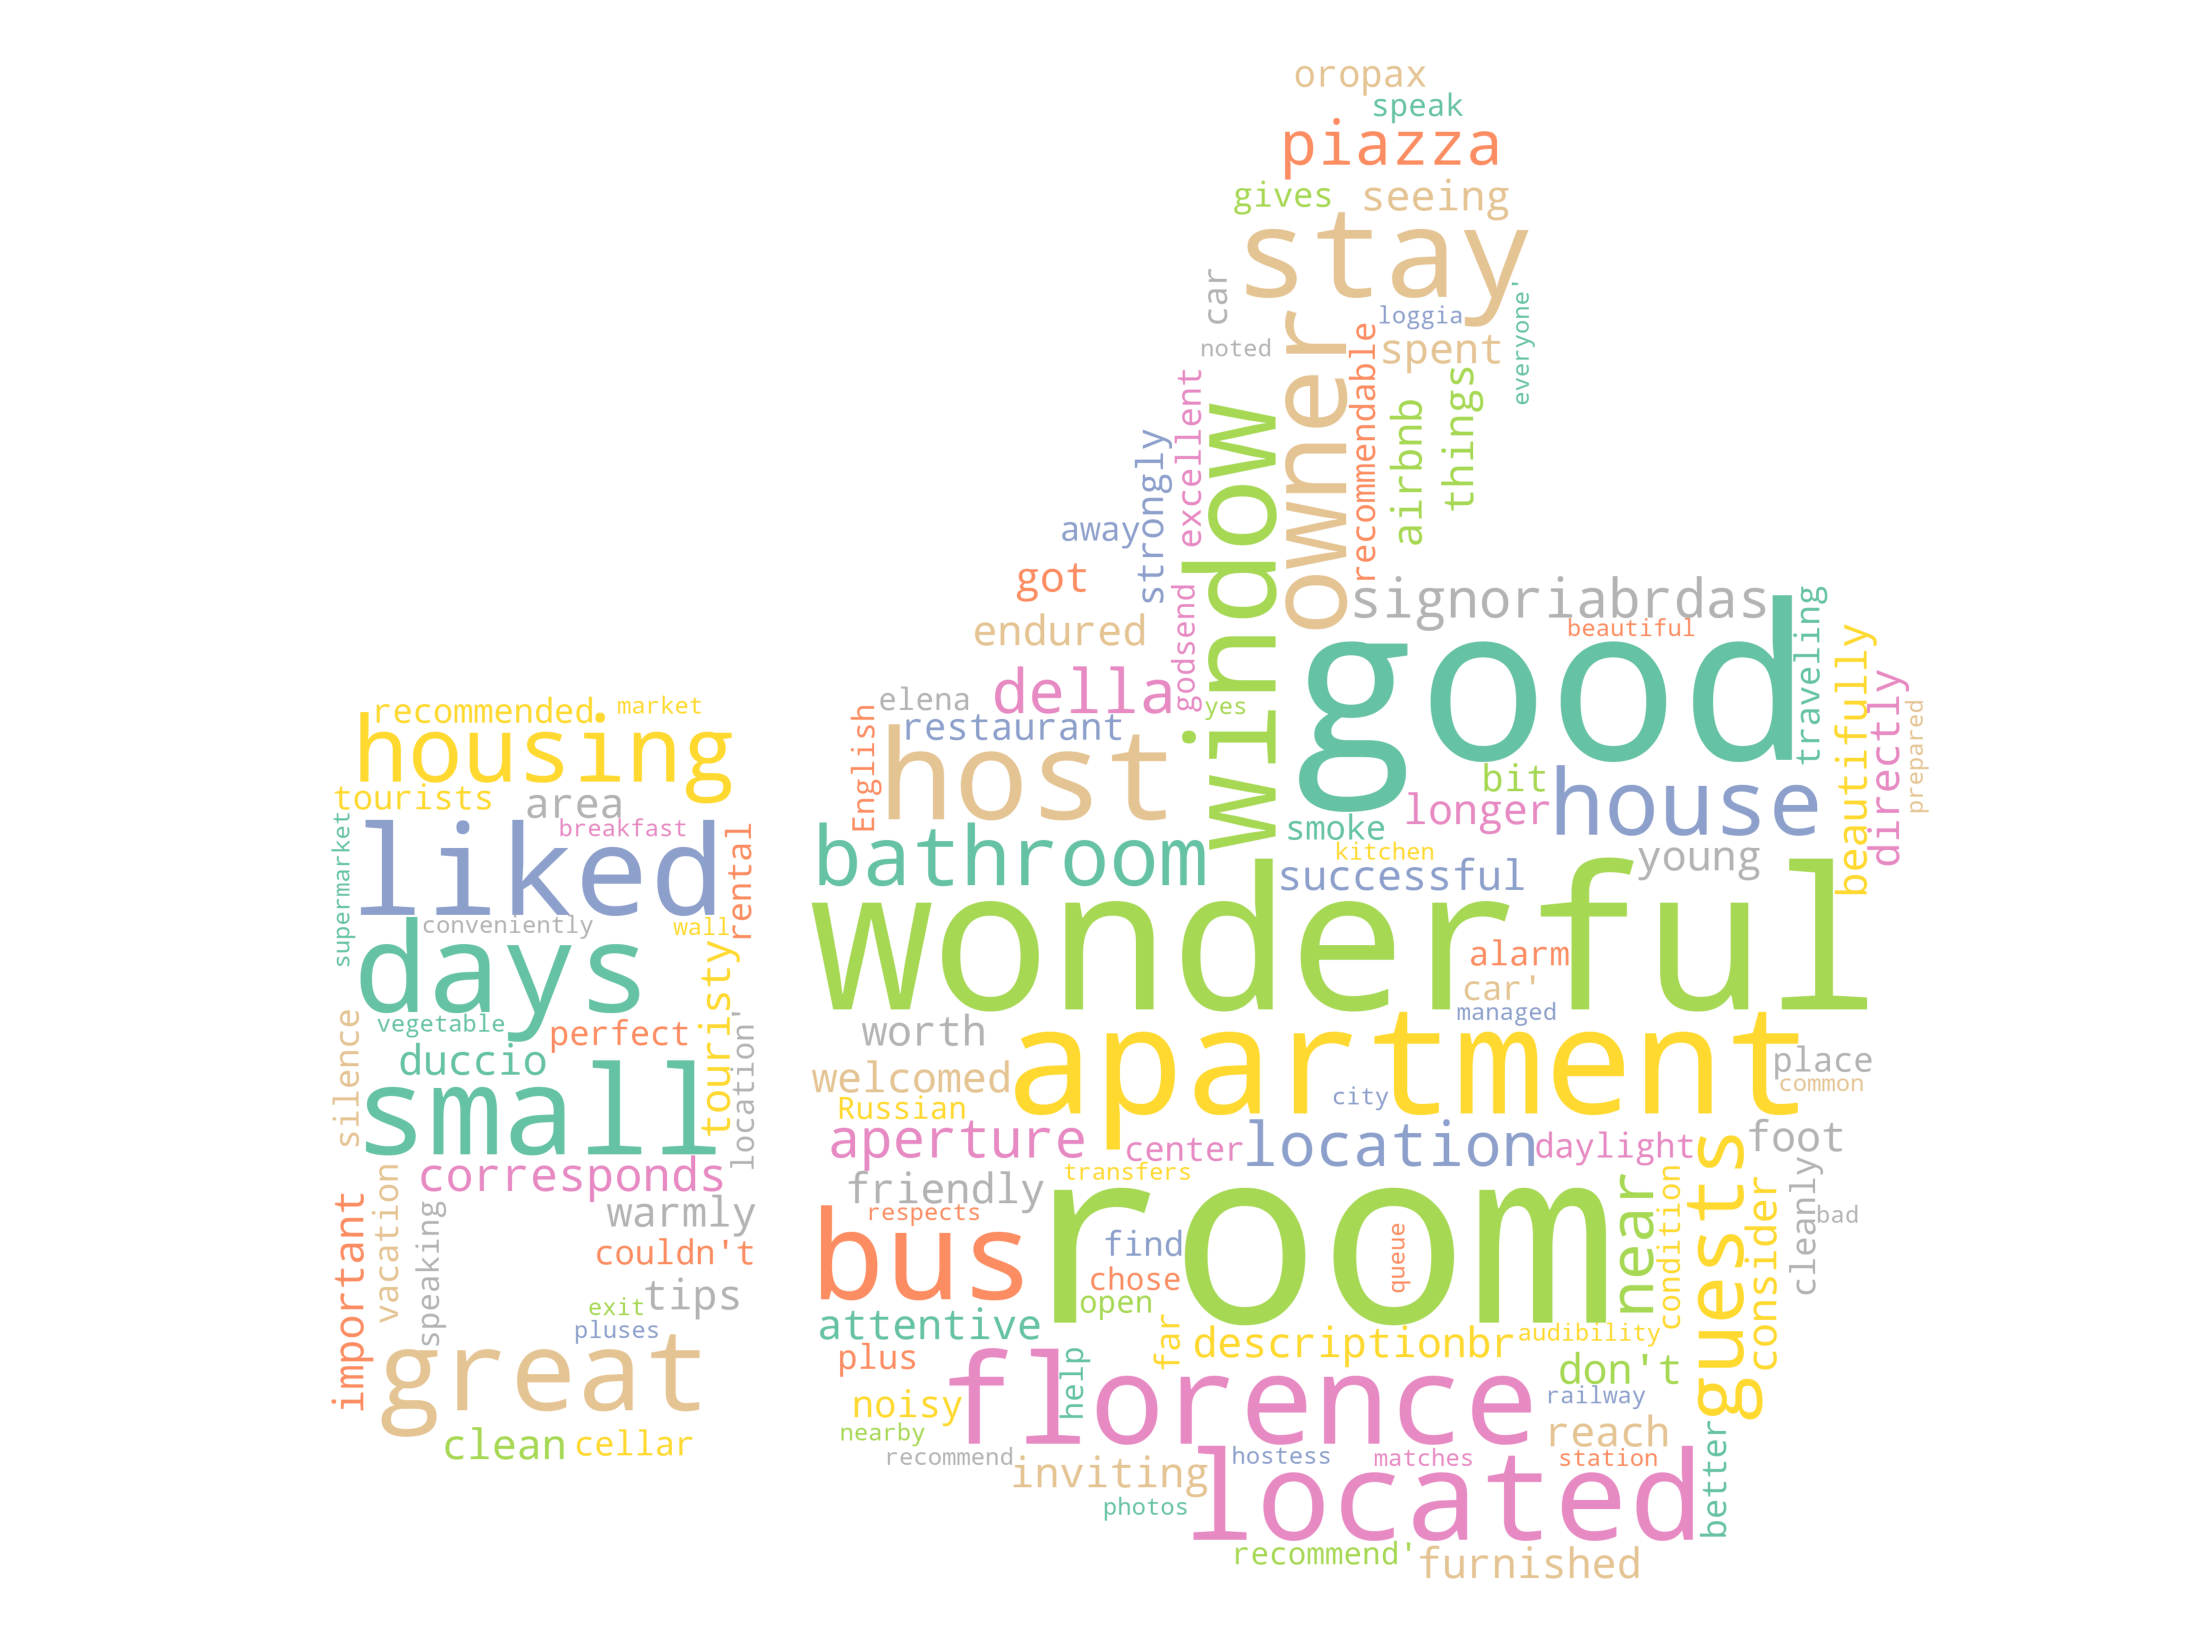

In [46]:
# Generate Word Cloud for positive reviews
text_pos = df_reviews_sample_sentiment['comments_english'][df_reviews_sample_sentiment['sentiment'] == 'pos'].values
image_pos = 'upvote.png'

gen_word_cloud(text_pos,image_pos)

Some **insights** filtering out common words like room, apartment, house, etc.. <br>

From **positive reviews**, it seems that guests in particular enjoyed:
- The location
- The main attractions
- Public transportation
- Tips
- The hospitality


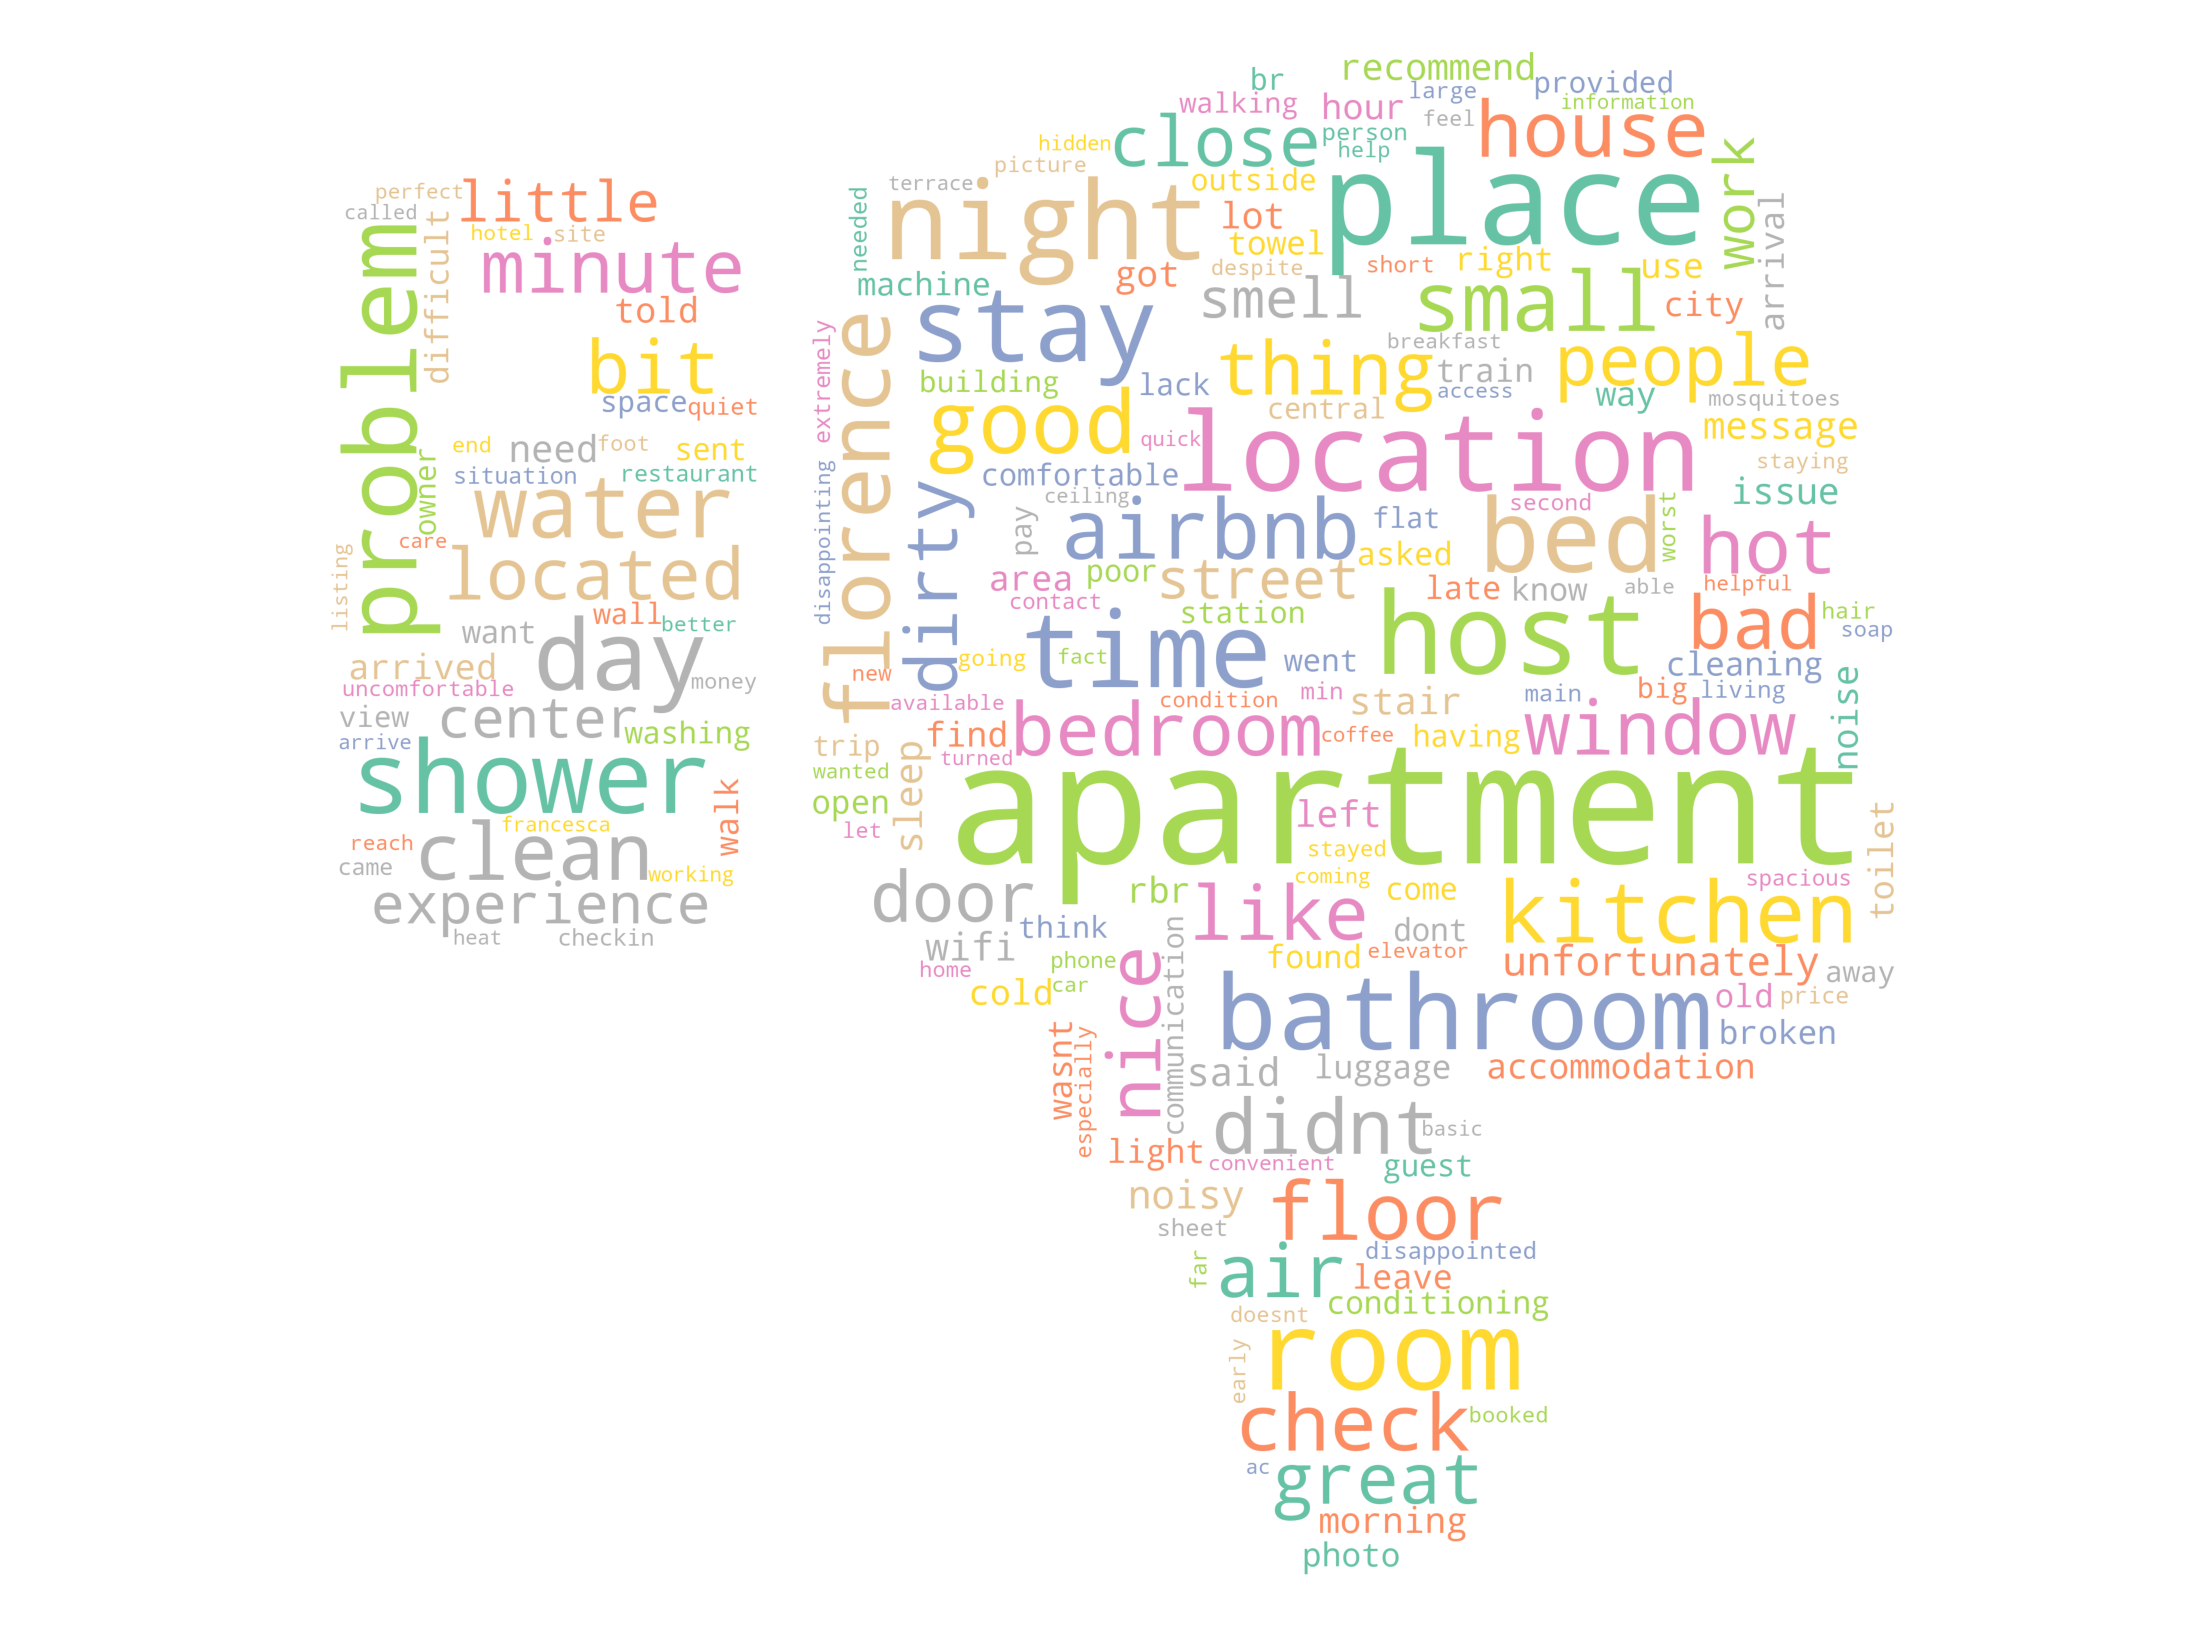

In [47]:
# Generate Word Cloud for negative reviews
text_neg = df_reviews_sample_sentiment['comments_english'][df_reviews_sample_sentiment['sentiment'] == 'neg'].values
image_neg = 'downvote.png'

gen_word_cloud(text_neg,image_neg)

From **negative reviews**, it seems that guests in particular didn't enjoyed: <br>
- Problems related to the bathroom, water more in general
- Cleanless
- Noise (at night)
- Smell
- Air conditioning (hot weather)
- The place

In [48]:
#df_reviews_sample_sentiment.to_pickle('./data/df_reviews_sample_sentiment_bitrigrams.pkl')

In [8]:
df_reviews_sample_sentiment_bitrigrams = pd.read_pickle('./data/df_reviews_sample_sentiment_bitrigrams.pkl')

[Back to TOC](#Table-of-Contents:)